## 수요와 공급 데이터를 이용해 주택이 오를 지역 찾기

### 1.부동산 수요 측정을 위한 데이터

데이터 전처리 함수에 입력으로 들어가는 시트명을 바꾸어가며 아파트 매매가와 전세가 지수 데이터를 얻어온다.

In [3]:
# 아파트 매매, 전세 지수 데이터 전처리 시키기
import xlwings as xw
import pandas as pd

def KBpriceindex_preprocessing(path, data_type):
    # path : KB 데이터 엑셀 파일의 디렉토리 (문자열)
    # data_type : 시트 name
    # data_type : '매매종합', '매매 APT', '매매연립', '매매단독', '전세종합' \
                         #  ,전세 APT', '전세연립', '전세단독' 중 하나
    
    wb = xw.Book(path)
    sheet = wb.sheets[data_type]
    row_num = sheet.range(1,1).end('down').end('down').end('down').row
    data_range = 'A2:GE' + str(row_num)
    raw_data = sheet[data_range].options(pd.DataFrame, index=False, header=True).value
    
    bignames = '서울 대구 부산 대전 광주 인천 울산 세종 경기 강원 충북 충남 전북 전남 경북 경남 제주도 6개광역시 5개광역시 수도권 기타지방 구분 전국'
    bigname_list = bignames.split(' ')
    big_col = list(raw_data.columns)
    small_col = list(raw_data.iloc[0])

    for num, gu_data in enumerate(small_col):
        if gu_data == None:
            small_col[num] = big_col[num]

        check = num
        while True:
            if big_col[check] in bigname_list:
                big_col[num] = big_col[check]
                break
            else:
                check = check - 1
                
    big_col[129] = '경기'
    big_col[130] = '경기'
    small_col[185] = '서귀포'
    
    raw_data.columns = [big_col, small_col]
    new_col_data = raw_data.drop([0,1]) # 필요없는 행을 지워준다.
    
    index_list = list(new_col_data['구분']['구분'])

    new_index = []

    for num, raw_index in enumerate(index_list):
        temp = str(raw_index).split('.')
        if int(temp[0]) > 12:
            if len(temp[0]) == 2:
                new_index.append('19' + temp[0] + '.' + temp[1])
            else:
                new_index.append(temp[0] + '.' + temp[1])
        else:
            new_index.append(new_index[num-1].split('.')[0] + '.' + temp[0])

    new_col_data.set_index(pd.to_datetime(new_index), inplace=True)
    #axis = 0 : 행방향동작 , axis = 1 : 열방향 동작
    cleaned_data = new_col_data.drop(('구분', '구분'), axis=1)
    return cleaned_data

In [6]:
path = r'데이터\★(월간)KB주택가격동향_시계열(2020.08).xlsx'
price_index = KBpriceindex_preprocessing(path, '매매APT')
jeonse_index = KBpriceindex_preprocessing(path, '전세APT')

### 2.파이썬으로 수요 데이터 분석하기

+ 아파트 매매가격 지수와 전세가격 지수 가져오기

KBpriceindex_preprocessing 함수를 가져와 실행하고 이를 이용해 아파트 매매가 지수, 전세가 지수를 데이터프레임으로 가져온다.

+ 가격지수 데이터프레임에서 특정 날짜를 기준으로 모든 지역 데이터 가져오기

매매가 지수와 전세가 지수를 이용해 특정 기준일로부터 1년전 값과 비교해서 증감률을 계산한다. 날짜를 입력하고 그 날짜를 기준으로 1년 전, 1년 후와 같은 상대 날짜를 계산하려면 두 가지 모듈이 필요하다.

datetime과 dateutil 모듈이다. datetime 모듈은 기본적으로 포함되어 있고 dateutil 모듈은 설치해야 한다.

datetime(년, 월, 일)과 같이 사용하고 dateutil은 날짜와 관련된 여러 가지 연산 기능을 위한 모듈로 특정 날짜를 기준으로 몇 달 전, 몇 달 후와 같은 상대 날짜를 계싼 하는데 사용한다.

In [44]:
# 매매가 지수 데이터프레임에서 특정 날짜를 기준으로 데이터 가져오기

from datetime import datetime
from dateutil.relativedelta import relativedelta

index_date = datetime(2020, 1, 1)
time_range = 12
# 2020년 1월 1일에서 12개월을 빼줌 -> 2019년, 1월 1일 (즉 1년전 날짜)
prev_date = index_date - relativedelta(months=time_range)

print(index_date)
print(prev_date)

price_index.loc[index_date]

2020-01-01 00:00:00
2019-01-01 00:00:00


전국    전국      100.103
서울    서울      103.606
      강북      102.734
      강북구     101.271
      광진구     105.129
               ...   
경남    김해      93.9843
      통영      98.8472
제주도   제주도        None
      서귀포     97.7055
기타지방  기타지방    96.7348
Name: 2020-01-01 00:00:00, Length: 186, dtype: object

In [32]:
price_index

전국       서울                                               \
                 전국       서울       강북      강북구      광진구      노원구      도봉구   
1986-01-01  20.9731  17.1529   24.274     None     None     None     None   
1986-02-01  20.9731  17.1827  24.2342     None     None     None     None   
1986-03-01  20.9345  17.1529  24.1944     None     None     None     None   
1986-04-01  20.8186   17.034  24.0352     None     None     None     None   
1986-05-01  20.6641  16.9448  23.7169     None     None     None     None   
...             ...      ...      ...      ...      ...      ...      ...   
2020-04-01  101.548  105.063  104.147  102.329  108.043  103.832  101.941   
2020-05-01  101.658  105.062  104.215  102.364  108.175  103.884  101.991   
2020-06-01  102.149  105.606  104.848  103.345  109.149  105.185  102.165   
2020-07-01  103.284  107.864  107.225  106.506  111.319  109.231   104.42   
2020-08-01  104.246  110.079   109.74  109.837  112.938   113.08  108.089   

                                       ...       경남                    \
               동대문구      마포구     서대문구  ...      의창구      진해구       양산   
1986-01-01     None     None     None  ...     None     None     None   
1986-02-01     None     None     None  ...     None     None     None   
1986-03-01     None     None     None  ...     None     None     None   
1986-04-01     None     None     None  ...     None     None     None   
1986-05-01     None     None     None  ...     None     None     None   
...             ...      ...      ...  ...      ...      ...      ...   
2020-04-01  103.442  106.704  105.453  ...  95.7475  96.6444  96.0182   
2020-05-01  103.473  106.781  105.622  ...  95.7475  96.6444  95.8665   
2020-06-01  103.838  107.678  106.172  ...  96.1654  96.6444  95.8188   
2020-07-01  105.566  109.598  107.863  ...  98.4272  96.6487  95.9559   
2020-08-01  106.978  111.228  109.139  ...  99.7522  96.6363  95.9412   

                                                 제주도              기타지방  
                 거제       진주       김해       통영   제주도      서귀포     기타지방  
1986-01-01     None     None     None     None  None     None     None  
1986-02-01     None     None     None     None  None     None     None  
1986-03-01     None     None     None     None  None     None     None  
1986-04-01     None     None     None     None  None     None     None  
1986-05-01     None     None     None     None  None     None     None  
...             ...      ...      ...      ...   ...      ...      ...  
2020-04-01  97.7239  94.0275  94.3282  98.4132  None  96.9815  96.7663  
2020-05-01  97.2554  93.9801  94.4447  98.3935  None  96.8373  96.7481  
2020-06-01  97.3304   93.926  94.5107  98.3504  None  96.6382  97.0128  
2020-07-01  98.0617  93.5458  94.5933  98.3504  None  96.5244  97.4653  
2020-08-01   97.803  93.5059  94.7789  98.3504  None  96.3808  97.9154  

[416 rows x 186 columns]

### 3. 특정 날짜를 기준으로 모든 지역의 가격지수 증감률을 계산

1년 전의 매매가격 지수를 가져오려면 price_index.loc[prev_date]라고 명령한다.

+ 증감률 = (현재 날짜 지수 값 - 이전 날짜 지수 값) / 이전 날짜 지수 값

In [17]:
# 1년 동안의 매매가 지수 증감 구하기

(price_index.loc[index_date] - price_index.loc[prev_date]) / price_index.loc[prev_date] 

전국    전국      0.00102727
서울    서울       0.0360552
      강북       0.0273394
      강북구      0.0127081
      광진구      0.0512948
                 ...    
경남    김해      -0.0601569
      통영       -0.011528
제주도   제주도            NaN
      서귀포      -0.022945
기타지방  기타지방    -0.0326525
Length: 186, dtype: object

### 계산한 가격지수 증감률 데이터를 데이터프레임 형태로 저장

In [26]:
# 매매가, 전세가 지수 증감률을 계산해서 데이터프레임 형태로 저장하기

demand_df = pd.DataFrame()
# 1년사이 증감률
demand_df['매매증감률'] = (price_index.loc[index_date] - price_index.loc[prev_date]) / price_index.loc[prev_date]
demand_df['전세증감률'] = (jeonse_index.loc[index_date] - jeonse_index.loc[prev_date]) / jeonse_index.loc[prev_date]
demand_df

매매증감률        전세증감률
전국   전국    0.00102727  -0.00648086
서울   서울     0.0360552   0.00496245
     강북     0.0273394  0.000353055
     강북구    0.0127081  -0.00524842
     광진구    0.0512948    0.0159401
...               ...          ...
경남   김해    -0.0601569   -0.0735392
     통영     -0.011528  -0.00123509
제주도  제주도          NaN          NaN
     서귀포    -0.022945  -0.00433929
기타지방 기타지방  -0.0326525   -0.0220008

[186 rows x 2 columns]

### 5. 기준 날짜의 매매가 지수와 지난 3년 동안의 최댓값 비교

주의할 점은 기준 날짜인 2020년 1월의 데이터는 빼야 하므로 마지막에서 하나 전까지만 데이터를 가져오라는 [:-1] 코드를 추가한다.

In [46]:
# 기준 날짜로부터 지난 3년간의 데이터 가져오기

# 기준날짜에서 3년을 빼준 값을 preve_date2에 할당
prev_date2 = index_date - relativedelta(months=time_range*3)
price_index[prev_date2:index_date][:-1]

전국       서울                                               \
                 전국       서울       강북      강북구      광진구      노원구      도봉구   
2017-01-01  95.8625  83.6799  84.7621   87.062  83.0318   85.184  84.3273   
2017-02-01  95.8663   83.712  84.8192  87.1227  82.9924  85.3111  84.3815   
2017-03-01  95.8833  83.7957  84.8876  87.1542   83.007  85.4563  84.4216   
2017-04-01  95.9159   83.911   84.988  87.2256  83.0513  85.5837  84.5425   
2017-05-01  95.9624  84.0954  85.1157  87.3018  83.2426  85.7195  84.6513   
2017-06-01  96.1766  84.8129  85.7676  87.6023  84.4789  86.6308  85.1853   
2017-07-01   96.427  85.5413  86.5229  87.8696   84.983   87.928  86.1326   
2017-08-01  96.7024    86.44   87.389  88.6433  86.0924  89.0067  87.3505   
2017-09-01  96.7567  86.5691  87.5596  88.9465  86.5273  88.9425  87.4265   
2017-10-01  96.8537  86.9553  87.9047  89.1701  87.2415  89.1132  87.7004   
2017-11-01    96.98  87.4942  88.3703  89.5528  88.4544  89.3219  88.0527   
2017-12-01  97.0968  88.0725   88.777  89.7843  89.3358  89.4983  88.4095   
2018-01-01  97.2988  89.0618   89.381  89.9225  90.7394  89.6321  88.8207   
2018-02-01  97.4972  89.9397   89.997  90.2517  92.1078  90.0334  89.0844   
2018-03-01  97.7636  91.0677  91.0304  90.6799  93.8976   90.724   89.578   
2018-04-01  97.8966  91.8071  91.6836  91.0572  94.5549  91.1696  90.1543   
2018-05-01   97.948  92.1726  92.0463  91.2819  94.7166  91.3508  90.9359   
2018-06-01  98.0026  92.5314  92.3843  91.7417  94.7193  91.4554  91.1742   
2018-07-01  98.0223  93.0204  92.9039  91.9075  95.0213  91.8042  91.5131   
2018-08-01  98.2492  94.1066  93.8299  92.3238  95.3939  92.7366  92.5774   
2018-09-01  99.3156  97.7155  97.3781  97.4254   98.136  96.9043   96.709   
2018-10-01  99.9258   99.512  99.3301  99.4855  99.6651  99.2299  98.9141   
2018-11-01   100.03  99.9051  99.8288  99.9023  99.9635  99.8544  99.6861   
2018-12-01  100.028  100.014  99.9964  99.9389      100  100.022    99.94   
2019-01-01      100      100      100      100      100      100      100   
2019-02-01  99.8856  99.9081  99.9683  100.016  99.9975  99.9625  99.9983   
2019-03-01  99.6933  99.7392  99.8989  99.9564  99.9421  99.9151  99.9862   
2019-04-01  99.4526  99.5953  99.8455  99.9312  99.8002  99.8461  99.9549   
2019-05-01  99.3148  99.5347   99.797  99.9115  99.7434  99.8361  99.9499   
2019-06-01  99.1176  99.4589  99.7112  99.8936  99.6576  99.7242  99.8876   
2019-07-01  99.0299  99.8266  100.021   100.04  100.121  100.133  100.208   
2019-08-01  99.0144  100.229  100.389  100.208  100.629  100.532   100.45   
2019-09-01  99.0415  100.677  100.799  100.419  101.198  100.795   100.72   
2019-10-01  99.1522   101.26  101.155  100.528  102.074  100.917  100.771   
2019-11-01   99.297   101.83  101.558  100.658  103.108  101.135  100.935   
2019-12-01  99.7259   102.92  102.204  100.955   104.44   101.51  101.201   

                                       ...       경남                    \
               동대문구      마포구     서대문구  ...      의창구      진해구       양산   
2017-01-01  84.2679  81.8458  85.2171  ...  112.747  111.085  102.364   
2017-02-01  84.3522  81.9313   85.275  ...  112.524  110.744  102.386   
2017-03-01  84.4079  81.9608  85.3795  ...  112.352  110.614  102.424   
2017-04-01   84.438  82.1235  85.4797  ...  112.266   110.45  102.278   
2017-05-01  84.5862  82.3144  85.5682  ...  112.032  109.931  102.233   
2017-06-01  84.9394  83.0512  85.7785  ...  111.624  109.805  102.147   
2017-07-01  85.5199  83.8164  86.2986  ...  111.053   109.64  101.968   
2017-08-01  86.3552  84.9226  86.9197  ...  110.645  109.209  101.906   
2017-09-01  86.6489  85.2931  87.1118  ...  110.159  108.199  101.774   
2017-10-01  86.9662  85.6803  87.5688  ...  109.487  108.075  101.702   
2017-11-01     87.3  86.4441  88.2315  ...  108.316  107.513   101.44   
2017-12-01  87.5834  87.2258  88.7503  ...  107.644  107.186  101.289   
2018-01-01  88.2308  88.3635  88.9961  ...  107.319  106.711  101.15

위의 데이터프레임에서 지역별로(데이터프레임의 각 컬럼별로) 최댓값을 찾는데 max()함수를 이용하는데 max() 함수는 각 컬럼의 최댓값을 구한 다음, 컬럼명이 인덱스이고 최댓값이 데이터 값인 시리즈를 반환한다.

In [49]:
price_index[prev_date2:index_date][:-1].max()

전국    전국      100.029606
서울    서울      102.919808
      강북      102.203567
      강북구     100.954568
      광진구     104.440280
                 ...    
경남    김해      111.729884
      통영      109.490780
제주도   제주도            NaN
      서귀포     101.454004
기타지방  기타지방    104.831444
Length: 186, dtype: float64

In [51]:
# demand_df 에 지난 최댓값과 기준 날짜 값의 최댓값 대비 증감률 저장

# 3년기준 이전 최댓값과 최댓값대비 증감률
demand_df['이전최댓값'] = price_index[prev_date2:index_date][:-1].max()
demand_df['최댓값대비증감률'] = (price_index.loc[index_date] - demand_df['이전최댓값']) / demand_df['이전최댓값']

In [66]:
# 이전최댓값*0.97 과 그 기준 대비 증감률을 뽑아본다.
# 최근에 부동산의 가격이 살짝 꺾여서 기준치를 살짝 낮추어 주기 위해
demand_df['이전최댓값*0.97'] = price_index[prev_date2:index_date][:-1].max()*0.97
demand_df['최댓값*0.97증감률'] = (price_index.loc[index_date] - demand_df['이전최댓값*0.97']) / demand_df['이전최댓값*0.97']

In [65]:
price_index[prev_date2:index_date][:-1].max()*0.97

전국    전국       97.028718
서울    서울       99.832214
      강북       99.137460
      강북구      97.925931
      광진구     101.307072
                 ...    
경남    김해      108.377988
      통영      106.206056
제주도   제주도            NaN
      서귀포      98.410384
기타지방  기타지방    101.686501
Length: 186, dtype: float64

In [55]:
demand_df

매매증감률        전세증감률       이전최댓값    최댓값대비증감률
전국   전국    0.00102727  -0.00648086  100.029606  0.00073099
서울   서울     0.0360552   0.00496245  102.919808  0.00666256
     강북     0.0273394  0.000353055  102.203567  0.00518942
     강북구    0.0127081  -0.00524842  100.954568   0.0031325
     광진구    0.0512948    0.0159401  104.440280  0.00659903
...               ...          ...         ...         ...
경남   김해    -0.0601569   -0.0735392  111.729884   -0.158826
     통영     -0.011528  -0.00123509  109.490780  -0.0972099
제주도  제주도          NaN          NaN         NaN         NaN
     서귀포    -0.022945  -0.00433929  101.454004  -0.0369478
기타지방 기타지방  -0.0326525   -0.0220008  104.831444  -0.0772353

[186 rows x 4 columns]

### 6. 지금까지 만든 수요 전략을 구현한다.

지난 1년동안 매매가가 상승한 지역을 찾아본다. 앞에서 계산한 매매가 지수 증감률이 양수인 지역만 찾으면 된다. 조금 더 강하게 조건을 설정하기 위해 증감률이 0.01보다 큰 지역만 찾는다. 1%도 오르지 않은 지역은 양수라도 변화가 거의 없다고 본다.

'매매증감률' 컬럼에서 값이 0.01이 넘으면 True이고, 아니면 False 이다.

In [56]:
demand_df['매매증감률'] > 0.01

전국    전국      False
서울    서울       True
      강북       True
      강북구      True
      광진구      True
              ...  
경남    김해      False
      통영      False
제주도   제주도     False
      서귀포     False
기타지방  기타지방    False
Name: 매매증감률, Length: 186, dtype: bool

In [57]:
# 매매가 지수와 전세가 지수의 상승여부를 계산해 demand_df에 저장

demand_df['매매가상승'] = demand_df['매매증감률'] > 0.01
demand_df['전세가상승'] = demand_df['전세증감률'] > 0.01

전세가 지수의 상승이 매매가 지수의 상승보다 더 크고 기준 날짜의 매매가 지수의 값이 3년 동안의 최댓값보다 큰지 알아본다.

In [59]:
# 전세가 지수 상승이 매매가 지수 상승보다 빠른 지와
# 기준 날짜의 매매가 지수 값이 지난 3년의 최댓값보다 큰지 계산하여 demand_df에 저장

demand_df['더빠른전세상승'] = demand_df['전세증감률'] > demand_df['매매증감률']
demand_df['최댓값대비상승'] = demand_df['최댓값대비증감률'] > 0

매매가 지수가 상승 했는지, 전세가 지수가 상승했는지, 전세가 지수의 상승이 매매가 지수의 상승보다 빠른지, 기준 날짜의 매매가 지수 값이 지난 3년 동안의 최댓값보다 큰지 등을 demand_df 만 보면 지역별로 확인할 수 있다.

In [67]:
demand_df

매매증감률        전세증감률       이전최댓값    최댓값대비증감률  매매가상승  전세가상승  \
전국   전국    0.00102727  -0.00648086  100.029606  0.00073099  False  False   
서울   서울     0.0360552   0.00496245  102.919808  0.00666256   True  False   
     강북     0.0273394  0.000353055  102.203567  0.00518942   True  False   
     강북구    0.0127081  -0.00524842  100.954568   0.0031325   True  False   
     광진구    0.0512948    0.0159401  104.440280  0.00659903   True   True   
...               ...          ...         ...         ...    ...    ...   
경남   김해    -0.0601569   -0.0735392  111.729884   -0.158826  False  False   
     통영     -0.011528  -0.00123509  109.490780  -0.0972099  False  False   
제주도  제주도          NaN          NaN         NaN         NaN  False  False   
     서귀포    -0.022945  -0.00433929  101.454004  -0.0369478  False  False   
기타지방 기타지방  -0.0326525   -0.0220008  104.831444  -0.0772353  False  False   

           더빠른전세상승  최댓값대비상승  이전최댓값*0.97 최댓값*0.97증감률  
전국   전국      False     True   97.028718   0.0316814  
서울   서울      False     True   99.832214   0.0377965  
     강북      False     True   99.137460   0.0362778  
     강북구     False     True   97.925931   0.0341572  
     광진구     False     True  101.307072    0.037731  
...            ...      ...         ...         ...  
경남   김해      False    False  108.377988    -0.13281  
     통영       True    False  106.206056  -0.0692885  
제주도  제주도     False    False         NaN         NaN  
     서귀포      True    False   98.410384 -0.00716266  
기타지방 기타지방     True    False  101.686501  -0.0486962  

[186 rows x 10 columns]

마지막으로 '매매상승가', '전세상승가', '더빠른전세상승', '최댓값대비상승' 컬럼이 모두True인 지역을 찾는다. 이를 위해 해당 컬럼의 각 값을 더해 저장한 새로운 컬럼을 만든다. 데이터프레임의 sum()함순든 True와 False의 값을 각각 1과 0으로 치환해 더한다. '매매상승가', '전세상승가', '더빠른전세상승', '최댓값대비상승', 컬럼을 선택하고, 행 기준으로 더하면 각 지역별로 총 몇 개의 True값이 있는지 확인할 수 있다. 선택된 4개의 컬럼으로 이루어진 데이터프레임에서 행을 기준으로 합계를 구하기 위해 sum()함수에 axis=1 이라는 옵션을 추가한다.

In [68]:
demand_df['0.97대비상승'] = demand_df['최댓값*0.97증감률'] > 0

In [69]:
demand_df

매매증감률        전세증감률       이전최댓값    최댓값대비증감률  매매가상승  전세가상승  \
전국   전국    0.00102727  -0.00648086  100.029606  0.00073099  False  False   
서울   서울     0.0360552   0.00496245  102.919808  0.00666256   True  False   
     강북     0.0273394  0.000353055  102.203567  0.00518942   True  False   
     강북구    0.0127081  -0.00524842  100.954568   0.0031325   True  False   
     광진구    0.0512948    0.0159401  104.440280  0.00659903   True   True   
...               ...          ...         ...         ...    ...    ...   
경남   김해    -0.0601569   -0.0735392  111.729884   -0.158826  False  False   
     통영     -0.011528  -0.00123509  109.490780  -0.0972099  False  False   
제주도  제주도          NaN          NaN         NaN         NaN  False  False   
     서귀포    -0.022945  -0.00433929  101.454004  -0.0369478  False  False   
기타지방 기타지방  -0.0326525   -0.0220008  104.831444  -0.0772353  False  False   

           더빠른전세상승  최댓값대비상승  이전최댓값*0.97 최댓값*0.97증감률  0.97대비상승  
전국   전국      False     True   97.028718   0.0316814      True  
서울   서울      False     True   99.832214   0.0377965      True  
     강북      False     True   99.137460   0.0362778      True  
     강북구     False     True   97.925931   0.0341572      True  
     광진구     False     True  101.307072    0.037731      True  
...            ...      ...         ...         ...       ...  
경남   김해      False    False  108.377988    -0.13281     False  
     통영       True    False  106.206056  -0.0692885     False  
제주도  제주도     False    False         NaN         NaN     False  
     서귀포      True    False   98.410384 -0.00716266     False  
기타지방 기타지방     True    False  101.686501  -0.0486962     False  

[186 rows x 11 columns]

In [71]:
# 지역별로 수요 조건의 총합 구하기

demand_df['수요총합'] = demand_df[['매매가상승','전세가상승','더빠른전세상승','최댓값대비상승','0.97대비상승']].sum(axis=1)

In [80]:
demand_df = demand_df[demand_df['수요총합'] == 4]

In [83]:
demand_df

매매증감률      전세증감률       이전최댓값    최댓값대비증감률  매매가상승  전세가상승  더빠른전세상승  \
서울 광진구   0.0512948  0.0159401  104.440280  0.00659903   True   True    False   
   용산구   0.0358609  0.0101633  102.840137  0.00725356   True   True    False   
   강서구   0.0209217  0.0188224  101.123915  0.00957489   True   True    False   
   금천구   0.0506132  0.0138525  103.996587   0.0102381   True   True    False   
   송파구   0.0566365  0.0318685  105.125120  0.00512274   True   True    False   
   양천구   0.0655784  0.0217167  104.859659   0.0161948   True   True    False   
대구 서구    0.0408147  0.0261782  103.354287  0.00703585   True   True    False   
   남구    0.0226584  0.0116627  101.855085  0.00403278   True   True    False   
   달성군   0.0032646  0.0150308  100.224203  0.00102028  False   True     True   
대전 대전    0.0799929  0.0246799  106.308035    0.015909   True   True    False   
   동구    0.0187378  0.0100388  101.421733   0.0044571   True   True    False   
   중구     0.103715  0.0148132  108.307325   0.0190584   True   True    False   
   서구     0.105962  0.0296326  107.570595    0.028127   True   True    False   
   유성구   0.0904084  0.0401688  108.362841  0.00625678   True   True    False   
세종 세종   0.00806235  0.0165416  100.351253  0.00453389  False   True     True   
경기 수원    0.0381747  0.0124692  102.096838    0.016853   True   True    False   
   영통구   0.0768629  0.0341453  104.402344   0.0314547   True   True    False   
   성남    0.0358451  0.0103424  102.710309  0.00851133   True   True    False   
   분당구   0.0330761  0.0134569  102.436337  0.00850547   True   True    False   
   부천    0.0374387  0.0153478  102.930225  0.00790484   True   True    False   
   과천    0.0467051  0.0180452  103.660547  0.00974297   True   True    False   

        최댓값대비상승  이전최댓값*0.97 최댓값*0.97증감률  0.97대비상승  수요총합  
서울 광진구     True  101.307072    0.037731      True     4  
   용산구     True   99.754933   0.0384057      True     4  
   강서구     True   98.090198   0.0407989      True     4  
   금천구     True  100.876690   0.0414826      True     4  
   송파구     True  101.971366    0.036209      True     4  
   양천구     True  101.713869   0.0476235      True     4  
대구 서구      True  100.253659   0.0381813      True     4  
   남구      True   98.799432   0.0350853      True     4  
   달성군     True   97.217477   0.0319797      True     4  
대전 대전      True  103.118794   0.0473288      True     4  
   동구      True   98.379081   0.0355228      True     4  
   중구      True  105.058106   0.0505757      True     4  
   서구      True  104.343478   0.0599247      True     4  
   유성구     True  105.111956   0.0373781      True     4  
세종 세종      True   97.340716    0.035602      True     4  
경기 수원      True   99.033933    0.048302      True     4  
   영통구     True  101.270274   0.0633553      True     4  
   성남      True   99.629000   0.0397024      True     4  
   분당구     True   99.363247   0.0396964      True     4  
   부천      True   99.842318   0.0390772      True     4  
   과천      True  100.550731   0.0409721      True     4

In [85]:
# demand_df 에서 원하는 지역만 남기기

demand_df.loc[[('서울','광진구'),('경기','수원')]]

,,매매증감률,전세증감률,이전최댓값,최댓값대비증감률,매매가상승,전세가상승,더빠른전세상승,최댓값대비상승,이전최댓값*0.97,최댓값*0.97증감률,0.97대비상승,수요총합
서울,광진구,0.0512948,0.0159401,104.440280,0.00659903,True,True,False,True,101.307072,0.037731,True,4
경기,수원,0.0381747,0.0124692,102.096838,0.016853,True,True,False,True,99.033933,0.048302,True,4


demand_df 에서 '전국'과 같이 큰 지역 단위의 지역을 제거한다. '앞 인덱스'와 '뒤 인덱스'가 다를 때만 따로 리스트에 저장한다. 이렇게 저장된 리스트를 이용해 demand_df 에서 loc() 함수를 이용해 원하는 인덱스만 남기고 다시 demand_df에 저장한다.

In [87]:
# 시군 단위의 인덱스만 남기기

selected_index = []

for name in demand_df.index:
    if name[0] is not name[1]:
        selected_index.append((name[0], name[1]))
        
demand_df = demand_df.loc[selected_index]

In [89]:
demand_df

매매증감률      전세증감률       이전최댓값    최댓값대비증감률  매매가상승  전세가상승  더빠른전세상승  \
서울 광진구  0.0512948  0.0159401  104.440280  0.00659903   True   True    False   
   용산구  0.0358609  0.0101633  102.840137  0.00725356   True   True    False   
   강서구  0.0209217  0.0188224  101.123915  0.00957489   True   True    False   
   금천구  0.0506132  0.0138525  103.996587   0.0102381   True   True    False   
   송파구  0.0566365  0.0318685  105.125120  0.00512274   True   True    False   
   양천구  0.0655784  0.0217167  104.859659   0.0161948   True   True    False   
대구 서구   0.0408147  0.0261782  103.354287  0.00703585   True   True    False   
   남구   0.0226584  0.0116627  101.855085  0.00403278   True   True    False   
   달성군  0.0032646  0.0150308  100.224203  0.00102028  False   True     True   
대전 동구   0.0187378  0.0100388  101.421733   0.0044571   True   True    False   
   중구    0.103715  0.0148132  108.307325   0.0190584   True   True    False   
   서구    0.105962  0.0296326  107.570595    0.028127   True   True    False   
   유성구  0.0904084  0.0401688  108.362841  0.00625678   True   True    False   
경기 수원   0.0381747  0.0124692  102.096838    0.016853   True   True    False   
   영통구  0.0768629  0.0341453  104.402344   0.0314547   True   True    False   
   성남   0.0358451  0.0103424  102.710309  0.00851133   True   True    False   
   분당구  0.0330761  0.0134569  102.436337  0.00850547   True   True    False   
   부천   0.0374387  0.0153478  102.930225  0.00790484   True   True    False   
   과천   0.0467051  0.0180452  103.660547  0.00974297   True   True    False   

        최댓값대비상승  이전최댓값*0.97 최댓값*0.97증감률  0.97대비상승  수요총합  
서울 광진구     True  101.307072    0.037731      True     4  
   용산구     True   99.754933   0.0384057      True     4  
   강서구     True   98.090198   0.0407989      True     4  
   금천구     True  100.876690   0.0414826      True     4  
   송파구     True  101.971366    0.036209      True     4  
   양천구     True  101.713869   0.0476235      True     4  
대구 서구      True  100.253659   0.0381813      True     4  
   남구      True   98.799432   0.0350853      True     4  
   달성군     True   97.217477   0.0319797      True     4  
대전 동구      True   98.379081   0.0355228      True     4  
   중구      True  105.058106   0.0505757      True     4  
   서구      True  104.343478   0.0599247      True     4  
   유성구     True  105.111956   0.0373781      True     4  
경기 수원      True   99.033933    0.048302      True     4  
   영통구     True  101.270274   0.0633553      True     4  
   성남      True   99.629000   0.0397024      True     4  
   분당구     True   99.363247   0.0396964      True     4  
   부천      True   99.842318   0.0390772      True     4  
   과천      True  100.550731   0.0409721      True     4

### 8. 수요 전략을 구현한 코드를 함수화

In [93]:
# 이전 코드를 정리해서 함수화 하기

def demand(price_index, jeonse_index, index_date, time_range):
    
    prev_date = index_date - relativedelta(months=time_range)
    prev_date2 = index_date - relativedelta(months=time_range*3)
    
    demand_df = pd.DataFrame()
    demand_df['매매증감률'] = (price_index.loc[index_date] - price_index.loc[prev_date]) / price_index.loc[prev_date]
    demand_df['전세증감률'] = (jeonse_index.loc[index_date] - jeonse_index.loc[prev_date]) / jeonse_index.loc[prev_date]
    
    # 3년기준 이전 최댓값과 최댓값대비 증감률
    demand_df['이전최댓값'] = price_index[prev_date2:index_date][:-1].max()
    demand_df['최댓값대비증감률'] = (price_index.loc[index_date] - demand_df['이전최댓값']) / demand_df['이전최댓값'].replace(0,None)

    # 이전최댓값*0.97 과 그 기준 대비 증감률을 뽑아본다.
    # 최근에 부동산의 가격이 살짝 꺾여서 기준치를 살짝 낮추어 주기 위해
    demand_df['이전최댓값*0.97'] = price_index[prev_date2:index_date][:-1].max()*0.97
    demand_df['최댓값*0.97증감률'] = (price_index.loc[index_date] - demand_df['이전최댓값*0.97']) / demand_df['이전최댓값*0.97'].replace(0,None)
    
    # 매매가 지수와 전세가 지수의 상승여부를 계산해 demand_df에 저장
    demand_df['매매가상승'] = demand_df['매매증감률'] > 0.01
    demand_df['전세가상승'] = demand_df['전세증감률'] > 0.01
    demand_df['0.97대비상승'] = demand_df['최댓값*0.97증감률'] > 0
    
    # 전세가 지수 상승이 매매가 지수 상승보다 빠른 지와
    # 기준 날짜의 매매가 지수 값이 지난 3년의 최댓값보다 큰지 계산하여 demand_df에 저장
    demand_df['더빠른전세상승'] = demand_df['전세증감률'] > demand_df['매매증감률']
    demand_df['최댓값대비상승'] = demand_df['최댓값대비증감률'] > 0
    # 지역별로 수요 조건의 총합 구하기

    demand_df['수요총합'] = demand_df[['매매가상승','전세가상승','더빠른전세상승','최댓값대비상승','0.97대비상승']].sum(axis=1)
    demand_df = demand_df[demand_df['수요총합'] == 4]
    
    # 시군 단위의 인덱스만 남기기

    selected_index = []

    for name in demand_df.index:
        if name[0] is not name[1]:
            selected_index.append((name[0], name[1]))

    demand_df = demand_df.loc[selected_index]
    
    return demand_df    

In [98]:
# demand 함수 사용 예시

path = r'데이터\★(월간)KB주택가격동향_시계열(2020.08).xlsx'
price_index = KBpriceindex_preprocessing(path, '매매APT')
jeonse_index = KBpriceindex_preprocessing(path, '전세APT')

index_date = datetime(2020, 1, 1)
time_range = 12

demand_ex = demand(price_index, jeonse_index, index_date, time_range)

In [99]:
demand_ex

매매증감률      전세증감률       이전최댓값    최댓값대비증감률  이전최댓값*0.97 최댓값*0.97증감률  \
서울 광진구  0.0512948  0.0159401  104.440280  0.00659903  101.307072    0.037731   
   용산구  0.0358609  0.0101633  102.840137  0.00725356   99.754933   0.0384057   
   강서구  0.0209217  0.0188224  101.123915  0.00957489   98.090198   0.0407989   
   금천구  0.0506132  0.0138525  103.996587   0.0102381  100.876690   0.0414826   
   송파구  0.0566365  0.0318685  105.125120  0.00512274  101.971366    0.036209   
   양천구  0.0655784  0.0217167  104.859659   0.0161948  101.713869   0.0476235   
대구 서구   0.0408147  0.0261782  103.354287  0.00703585  100.253659   0.0381813   
   남구   0.0226584  0.0116627  101.855085  0.00403278   98.799432   0.0350853   
   달성군  0.0032646  0.0150308  100.224203  0.00102028   97.217477   0.0319797   
대전 동구   0.0187378  0.0100388  101.421733   0.0044571   98.379081   0.0355228   
   중구    0.103715  0.0148132  108.307325   0.0190584  105.058106   0.0505757   
   서구    0.105962  0.0296326  107.570595    0.028127  104.343478   0.0599247   
   유성구  0.0904084  0.0401688  108.362841  0.00625678  105.111956   0.0373781   
경기 수원   0.0381747  0.0124692  102.096838    0.016853   99.033933    0.048302   
   영통구  0.0768629  0.0341453  104.402344   0.0314547  101.270274   0.0633553   
   성남   0.0358451  0.0103424  102.710309  0.00851133   99.629000   0.0397024   
   분당구  0.0330761  0.0134569  102.436337  0.00850547   99.363247   0.0396964   
   부천   0.0374387  0.0153478  102.930225  0.00790484   99.842318   0.0390772   
   과천   0.0467051  0.0180452  103.660547  0.00974297  100.550731   0.0409721   

        매매가상승  전세가상승  0.97대비상승  더빠른전세상승  최댓값대비상승  수요총합  
서울 광진구   True   True      True    False     True     4  
   용산구   True   True      True    False     True     4  
   강서구   True   True      True    False     True     4  
   금천구   True   True      True    False     True     4  
   송파구   True   True      True    False     True     4  
   양천구   True   True      True    False     True     4  
대구 서구    True   True      True    False     True     4  
   남구    True   True      True    False     True     4  
   달성군  False   True      True     True     True     4  
대전 동구    True   True      True    False     True     4  
   중구    True   True      True    False     True     4  
   서구    True   True      True    False     True     4  
   유성구   True   True      True    False     True     4  
경기 수원    True   True      True    False     True     4  
   영통구   True   True      True    False     True     4  
   성남    True   True      True    False     True     4  
   분당구   True   True      True    False     True     4  
   부천    True   True      True    False     True     4  
   과천    True   True      True    False     True     4

### 9. 수요 전략으로 선택된 지역을 그래프로 확인

KB 부동산 데이터에서 매매가 지수와 전세가 지수를 가지고 각 지역의 수요를 예측할 수 있는 코드를 만들었다. 최종적으로 조건에 맞는 지역만 남은 demand_ex를 얻었다. 이 데이터프레임에 남은 지역은 지난 1년 동안 전세가 매매가보다 더 빠르게 상승하고 지난 3년간 매매지수 최댓값*(0.97)을 기준으로 기준 날짜의 매매지수가 넘어서서 실수요가 매매가 상승으로 이어질 가능성이 높은 지역들이다. 이를 그래프로 시각화한다.

### 10. 그래프를 그리기 위한 기본 설정

In [100]:
# matplotlib를 불러오고 한글폰트
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_name = font_manager.FontProperties(fname = "C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
# 맥 OS인 경우 위 두 줄을 입력하지 않고 아래 코드를 입력하면 된다.
# rc('font', family='AppleGothc')
plt.rcParams['axes.unicode_minus'] = False

### 11. 2020년 1월을 기준으로 남아있던 서울 동대문구 지역의 그래프를 그린다.

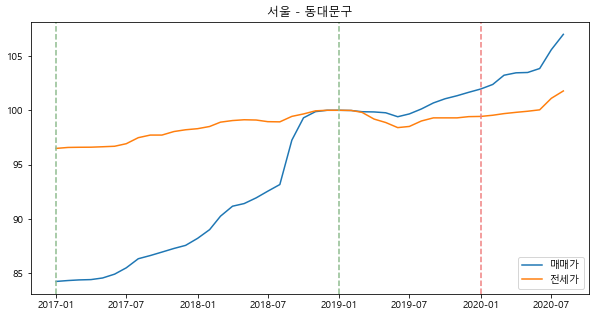

In [101]:
# 특정 날짜를 기준으로 서울 동대문구 그래프 그리기

si = '서울'
gu = '동대문구'
index_date = datetime(2020, 1, 1)

prev_date = index_date - relativedelta(months=12)
prev_date2 = index_date -relativedelta(months=36)
graph_start = index_date - relativedelta(years=3)
graph_end = index_date + relativedelta(years=3)

plt.figure(figsize=(10,5))
plt.title(si + ' - ' + gu)
plt.plot(price_index[si][gu][graph_start:graph_end], label='매매가')
plt.plot(jeonse_index[si][gu][graph_start:graph_end], label='전세가')

plt.axvline(x=index_date, color='lightcoral', linestyle='--')
plt.axvline(x=prev_date, color='darkseagreen', linestyle='--')
plt.axvline(x=prev_date2, color='darkseagreen', linestyle='--')
plt.legend()
plt.show()

#### subplot을 이용해 수요 전략에 따라 선택된 모든 지역의 그래프를 확인.

데이터프레임의 인덱스에 저장된 지역명의 정보를 demand_ex로 가져온다.

In [104]:
# 수요 전략의 결과 데이터프레임에서 지역 이름 가져오기

for name in demand_ex.index:
    print(name)

('서울', '광진구')
('서울', '용산구')
('서울', '강서구')
('서울', '금천구')
('서울', '송파구')
('서울', '양천구')
('대구', '서구')
('대구', '남구')
('대구', '달성군')
('대전', '동구')
('대전', '중구')
('대전', '서구')
('대전', '유성구')
('경기', '수원')
('경기', '영통구')
('경기', '성남')
('경기', '분당구')
('경기', '부천')
('경기', '과천')


이를 KB 부동산 데이터의 매매가 지수나 전세가 지수 데이터프레임에서 특정 지역의 데이터를 가져오는데 사용한다.

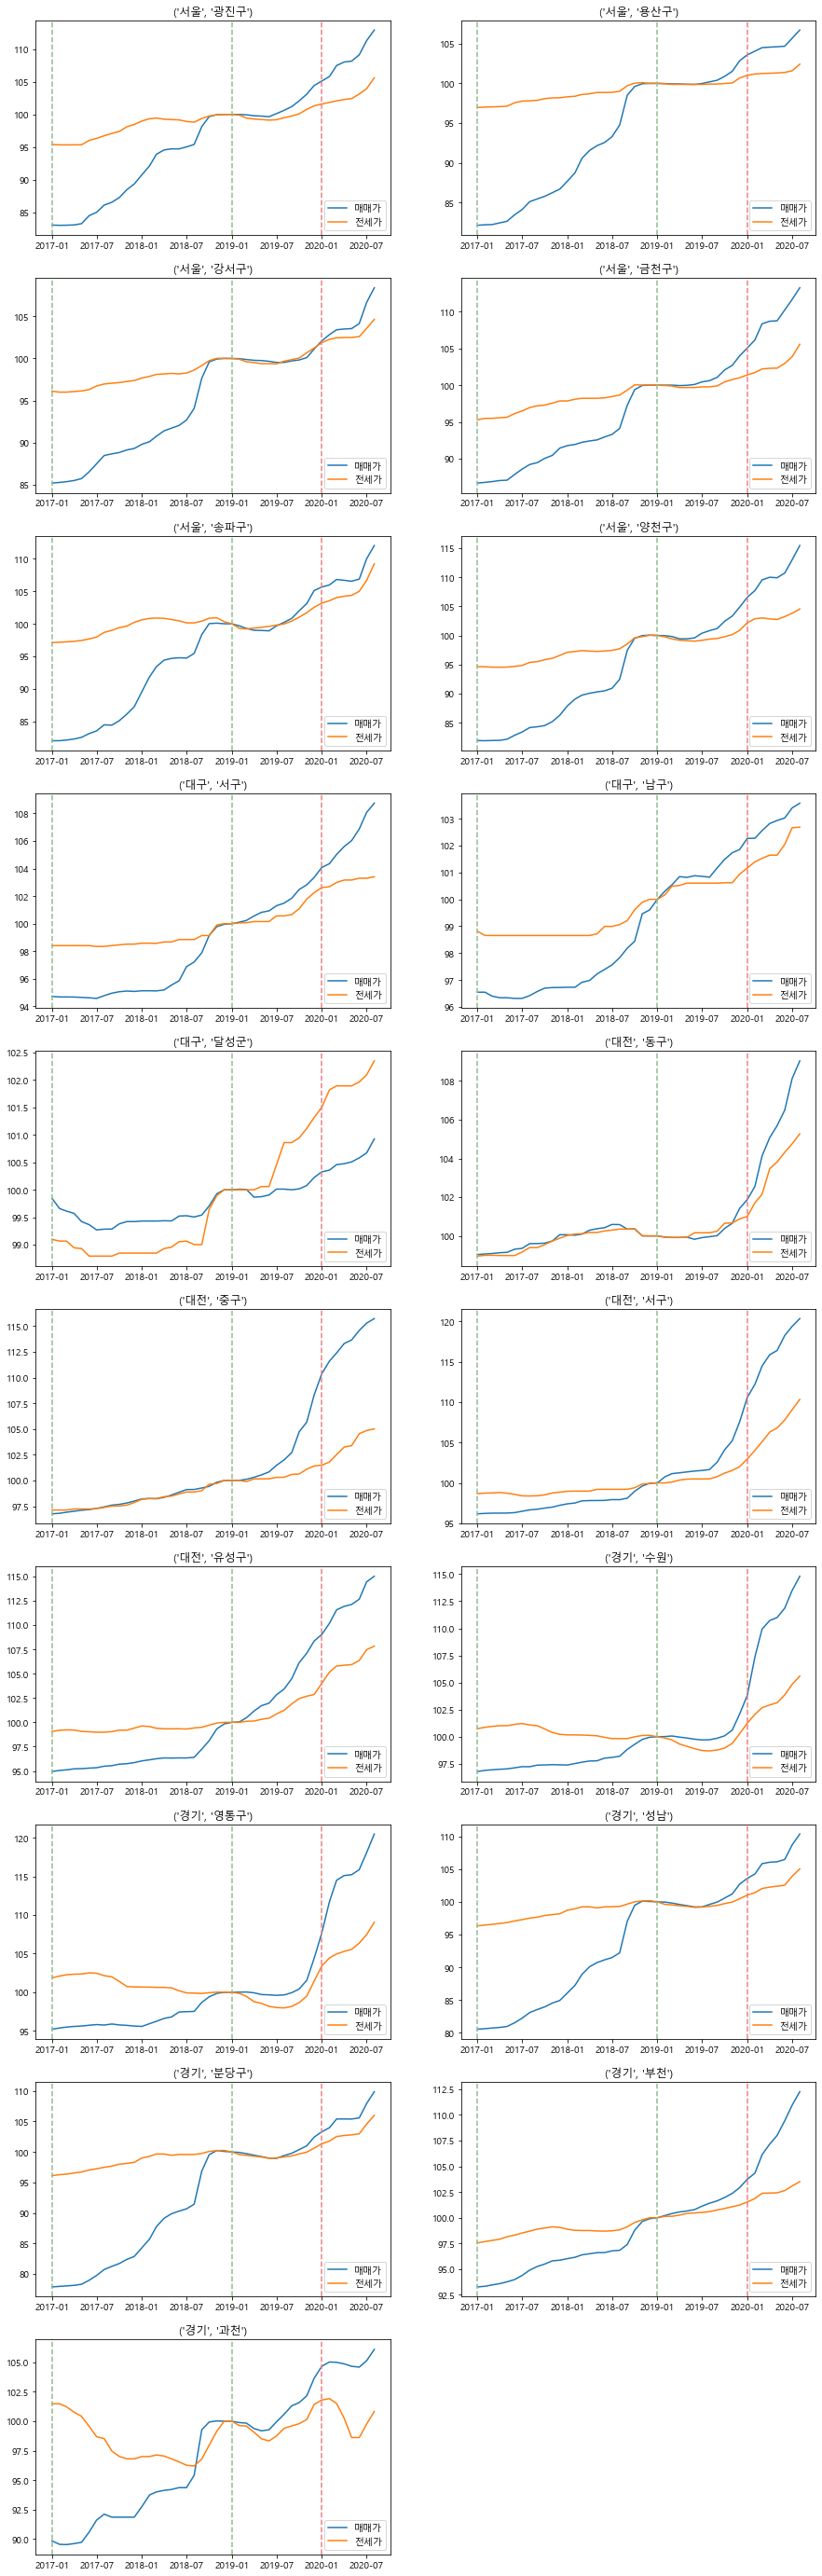

In [105]:
# demand 함수를 이용해 선택된 전 지역의 그래프 그리기
index_date = datetime(2020, 1, 1)

time_range = 12
prev_date = index_date - relativedelta(months=time_range)
prev_date2 = index_date - relativedelta(months=time_range * 3)
graph_start = index_date - relativedelta(months=time_range * 3)
graph_end = index_date + relativedelta(months=time_range * 3)

num_row = int((len(demand_ex.index)-1)/2)+1

plt.figure(figsize=(15, num_row*5))
for i, spot in enumerate(demand_ex.index):
    plt.subplot(num_row, 2, i+1)
    plt.title(spot)
    si = spot[0]
    gu = spot[1]
    plt.plot(price_index[si][gu][graph_start:graph_end], label='매매가')
    plt.plot(jeonse_index[si][gu][graph_start:graph_end], label='전세가')
    plt.axvline(x=index_date, color='lightcoral', linestyle='--')
    plt.axvline(x=prev_date, color='darkseagreen', linestyle='--')
    plt.axvline(x=prev_date2, color='darkseagreen', linestyle='--')
    plt.legend(loc='lower right')
    
plt.show()